In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit as logistic


from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std()

## Ex. 1

The data in data(NWOGrants) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012. These data have a very similar structure to the UCBAdmit data discussed in Chapter 11. Draw a DAG for this sample and then use one or more binomial GLMs to estimate the TOTAL causal effect of gender on grant awards.

<Axes:>

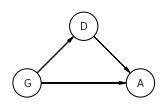

In [6]:
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "D": (1, 1),
    "G": (0, 0),
    "A": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

In [7]:
df = pd.read_csv('data/NWOGrants.csv', sep=';')

In [8]:
gender_id = pd.factorize(df.gender)[0]
gender_idx = pd.factorize(df.gender)[1]

In [9]:
df.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i] \\
\alpha &\sim Normal(0, 1) \\

\end{aligned}\end{split}




In [12]:
#check prior implications
with pm.Model() as m5_1:
        a = pm.Normal("a", 0, 1)
        p = pm.Deterministic("p", pm.math.invlogit(a))

        awards = pm.Binomial("awards", 1, p, observed=df.awards)
        
        prior_5_1 = pm.sample_prior_predictive()
        
idata_5_1 = az.from_pymc3(prior=prior_5_1, model=m5_1)    


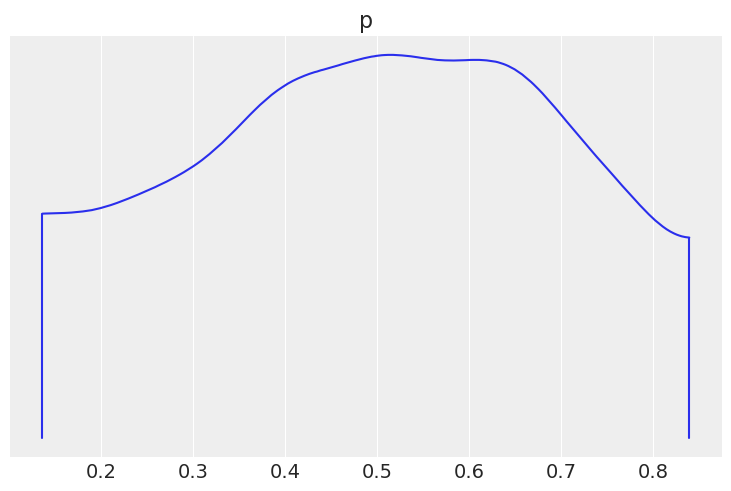

In [13]:
ax = az.plot_density(
    [idata_5_1],
    var_names =["p"],   
    point_estimate=None,
    group="prior")

In [19]:
with pm.Model() as m5_2:

        a = pm.Normal("a", 0, 1, shape=len(gender_idx)) #one for each gender
        p = pm.Deterministic("p", pm.math.invlogit(a[gender_id]))

        awards = pm.Binomial("awards", p=p, n=df.applications, observed=df.awards)
        
        prior_5_2 = pm.sample_prior_predictive()
        trace_5_2 = pm.sample(draws=10000)

idata_5_2 = az.from_pymc3(trace_5_2,model=m5_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 15 seconds.


In [20]:
pm.summary(trace_5_2, var_names=['a'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.529,0.065,-1.652,-1.407,0.0,0.0,35928.0,28607.0,1.0
a[1],-1.733,0.082,-1.889,-1.580,0.0,0.0,36297.0,26958.0,1.0


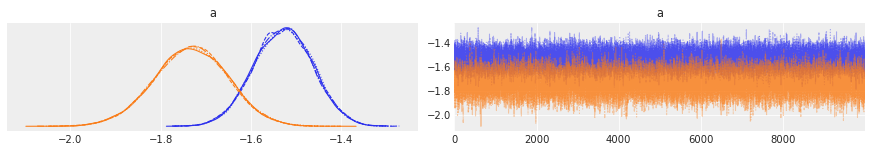

In [21]:
with m5_2:
    tr = pm.plot_trace(trace_5_2, var_names=['a'])
tr;    

In [22]:
#difference calculations using inference data object
diff_a = idata_5_2['posterior']['a'].sel(a_dim_0=0).values - idata_5_2['posterior']['a'].sel(a_dim_0=1).values
diff_p = logistic(idata_5_2['posterior']['a'].sel(a_dim_0=0).values) - logistic(idata_5_2['posterior']['a'].sel(a_dim_0=1).values)
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.20,0.10,0.02,0.41
diff_p,0.03,0.01,0.00,0.06


In [23]:
#the same calculation using trace
diff_a_1 = trace_5_2["a"][:,0] - trace_5_2["a"][:,1]
diff_p_1 = logistic(trace_5_2["a"][:,0]) - logistic(trace_5_2["a"][:,1])
az.summary({"diff_a": diff_a_1, "diff_p": diff_p_1}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.20,0.10,0.02,0.41
diff_p,0.03,0.01,0.00,0.06


Text(0.5, 1.0, 'M-F contrast')

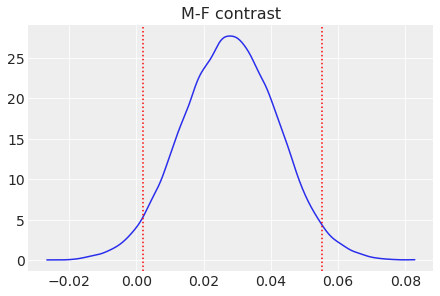

In [24]:
hdi_l, hdi_h = az.hdi(diff_p_1)
hdi_l, hdi_h

fig, ax = plt.subplots()
az.plot_kde(diff_p_1, ax=ax)
ax.axvline(x=hdi_l,color='red',linestyle=':')
ax.axvline(x=hdi_h,color='red',linestyle=':')

ax.set_title('M-F contrast')

Given the M-F contrast, we can conclude that men are more likely to be awarded then women

## Ex. 2

Now estimate the DIRECT causal effect of gender on grant awards. Compute the average direct causal effect of gender, weighting each discipline in proportion to the number of applications in the sample. Refer to the marginal effect example in Lecture 9 for help.

### 1) Linear model with parameters for gender and discipline

In [10]:
df = pd.read_csv('data/NWOGrants.csv', sep=';')

In [11]:
#do a quick numbers check
x = df.groupby(['discipline','gender']).agg({
    'applications':'sum',
    'awards':'sum'
}).reset_index()

x['award_rate'] = round(x['awards']/x['applications'],2)
x.sort_values(by=['discipline','gender'])


,discipline,gender,applications,awards,award_rate
0,Chemical sciences,f,39,10,0.26
1,Chemical sciences,m,83,22,0.27
2,Earth/life sciences,f,126,18,0.14
3,Earth/life sciences,m,156,38,0.24
4,Humanities,f,166,32,0.19
5,Humanities,m,230,33,0.14
6,Interdisciplinary,f,78,17,0.22
7,Interdisciplinary,m,105,12,0.11
8,Medical sciences,f,260,29,0.11
9,Medical sciences,m,245,46,0.19


In [12]:
gender_id = pd.factorize(df.gender)[0]
gender_idx = pd.factorize(df.gender)[1]

discipline_id = pd.factorize(df.discipline)[0]
discipline_idx = pd.factorize(df.discipline)[1]

In [13]:
df.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i] + \delta[D_i] \\
\alpha &\sim Normal(0, 1.5) \\
\delta &\sim Normal(0, 1.5) \\


\end{aligned}\end{split}




In [14]:
with pm.Model() as m5_3:

        #define input data
        gender_id = pm.Data("gender_id", gender_id)
        discipline_id = pm.Data("discipline_id", discipline_id)
        applications = pm.Data("applications", df.applications)
        awards = pm.Data("awards", df.awards)

        a = pm.Normal("a", 0.0, 1.5, shape=len(gender_idx))
        delta = pm.Normal("delta", 0, 1.5, shape=len(discipline_idx))

        p = pm.Deterministic("p", pm.math.invlogit(a[gender_id] + delta[discipline_id]))

        awards_hat = pm.Binomial("awards_hat", p=p, n=applications, observed=awards)
        
        prior_5_3 = pm.sample_prior_predictive()
        trace_5_3 = pm.sample(draws=10000)

idata_5_3 = az.from_pymc3(trace_5_3,model=m5_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.881060680983059, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


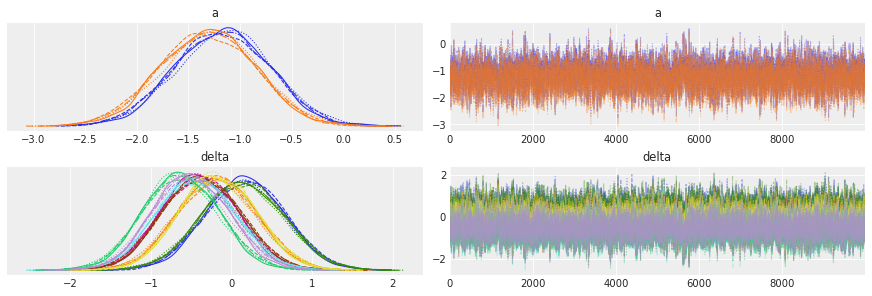

In [28]:
with m5_3:
    tr = pm.plot_trace(trace_5_3, var_names=['a','delta'])
tr;

In [29]:
with m5_3:
    sum = pm.summary(trace_5_3, var_names=['a','delta'])
sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.170,0.464,-2.044,-0.314,0.008,0.005,3765.0,5075.0,1.0
a[1],-1.309,0.467,-2.186,-0.444,0.008,0.005,3821.0,5277.0,1.0
delta[0],0.165,0.497,-0.768,1.090,0.008,0.005,4236.0,6580.0,1.0
delta[1],-0.188,0.492,-1.094,0.747,0.008,0.005,4188.0,5890.0,1.0
delta[2],0.136,0.518,-0.822,1.119,0.008,0.005,4641.0,7807.0,1.0
delta[3],-0.405,0.479,-1.283,0.500,0.008,0.005,3971.0,5606.0,1.0
delta[4],-0.378,0.487,-1.267,0.548,0.008,0.005,4125.0,6060.0,1.0
delta[5],-0.448,0.497,-1.343,0.503,0.008,0.005,4307.0,6741.0,1.0
delta[6],-0.171,0.481,-1.049,0.753,0.008,0.005,4011.0,5810.0,1.0
delta[7],-0.629,0.471,-1.510,0.247,0.008,0.005,3895.0,5475.0,1.0


In [30]:
#average difference when controlling for discipline
diff2_a_1 = trace_5_3["a"][:,0] - trace_5_3["a"][:,1]
diff2_p_1 = logistic(trace_5_3["a"][:,0]) - logistic(trace_5_3["a"][:,1])
az.summary({"diff_a": diff2_a_1, "diff_p": diff2_p_1}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.14,0.11,-0.06,0.34
diff_p,0.02,0.02,-0.01,0.06


[Text(0.5, 1.0, 'M-F contrast of direct effect of gender')]

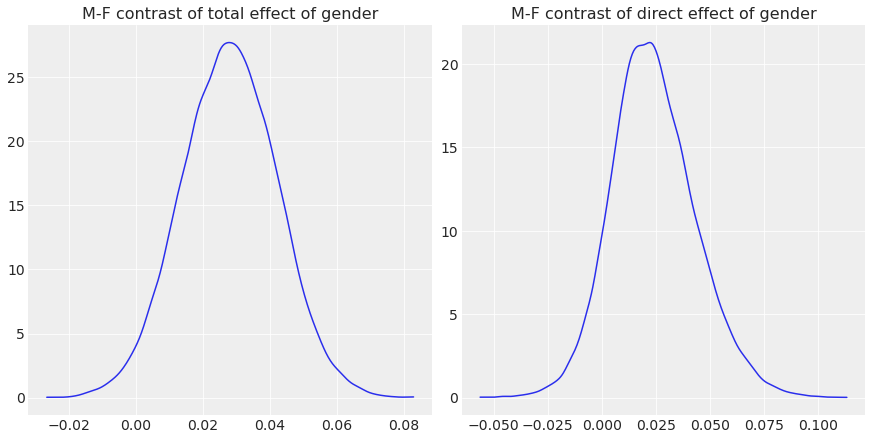

In [31]:
#Comparing M-F contrasts for total effect and direct effect

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

az.plot_kde(diff_p_1, ax=ax1)
ax1.set(title='M-F contrast of total effect of gender')

az.plot_kde(diff2_p_1, ax=ax2)
ax2.set(title='M-F contrast of direct effect of gender')


We see that when controlling for discipline effects, the effect of gender are greatly diminished.

### 2) Matrix model with a parameter for each combination of gender and discipline

Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i][D_i] \\
\alpha &\sim Normal(0, 1.5) \\
\delta &\sim Normal(0, 1.5) \\


\end{aligned}\end{split}


In [129]:
with pm.Model() as m5_4:

        #define input data
        gender_id = pm.Data("gender_id", gender_id)
        discipline_id = pm.Data("discipline_id", discipline_id)
        applications = pm.Data("applications", df.applications)
        awards = pm.Data("awards", df.awards)

        a = pm.Normal("a", 0.0, 1.5, shape=(len(gender_idx), len(discipline_idx)))

        p = pm.Deterministic("p", pm.math.invlogit(a[gender_id, discipline_id]))

        awards_hat = pm.Binomial("awards_hat", p=p, n=applications, observed=awards)
        
        prior_5_4 = pm.sample_prior_predictive()
        trace_5_4 = pm.sample(draws=10000)

idata_5_4 = az.from_pymc3(trace_5_4,model=m5_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.


In [130]:
with m5_4:
    sum = pm.summary(trace_5_4, var_names=['a','p'])
sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-1.007,0.244,-1.460,-0.545,0.001,0.001,57784.0,30031.0,1.0
"a[0, 1]",-1.417,0.216,-1.831,-1.018,0.001,0.001,58875.0,28993.0,1.0
"a[0, 2]",-0.984,0.272,-1.496,-0.481,0.001,0.001,56210.0,30695.0,1.0
"a[0, 3]",-1.772,0.186,-2.125,-1.424,0.001,0.001,59609.0,30585.0,1.0
"a[0, 4]",-1.652,0.196,-2.015,-1.283,0.001,0.001,59622.0,29925.0,1.0
"a[0, 5]",-1.999,0.293,-2.554,-1.452,0.001,0.001,59102.0,28647.0,1.0
"a[0, 6]",-1.124,0.185,-1.484,-0.791,0.001,0.001,59819.0,30094.0,1.0
"a[0, 7]",-1.705,0.135,-1.949,-1.446,0.001,0.000,58611.0,28976.0,1.0
"a[0, 8]",-1.455,0.162,-1.769,-1.159,0.001,0.000,56968.0,28701.0,1.0
"a[1, 0]",-1.034,0.355,-1.719,-0.386,0.001,0.001,57667.0,29669.0,1.0


In [82]:
#difference per discipline M-F
results = np.zeros((len(discipline_idx), 40000))

for i in range(len(discipline_idx)):
    results[i] = logistic(trace_5_4["a"][:,0][:,i])  - logistic(trace_5_4["a"][:,1][:,i]) 

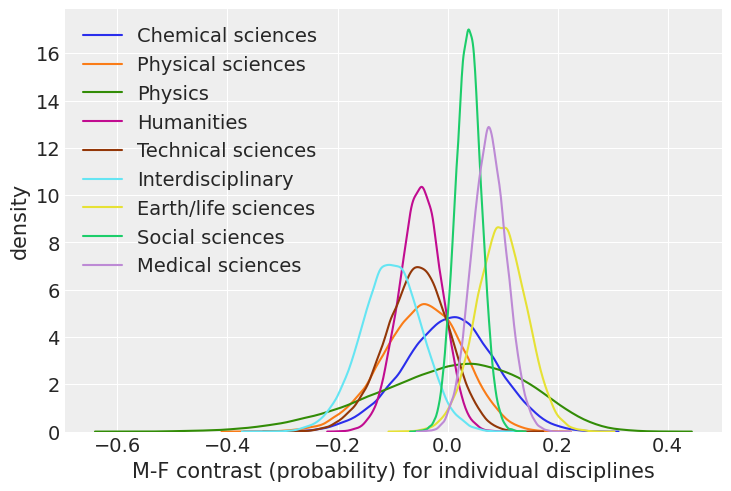

In [136]:
fig, ax = plt.subplots()
ax.set_xlabel('M-F contrast (probability) for individual disciplines')
ax.set_ylabel('density')

for i in range(len(discipline_idx)):
    sns.kdeplot(results[i], ax=ax)

ax.legend(labels=discipline_idx)


In [98]:
#averaging over the differences using simulation

discipline_ids = list(range(0,9))

#1) create a list of applications by departments
apps_per_dept = [df[discipline_id == i]['applications'].sum() for i in discipline_ids]

result = []
for i, c in enumerate(apps_per_dept):
    res = [i for x in range(0,c)]
    result.append(res)

result_flat = [item for sublist in result for item in sublist]


In [107]:
#if applicants were all men
p_men = np.zeros((len(result_flat), 40000))

for e,i in enumerate(result_flat):
        p_men[e] = logistic(trace_5_4["a"][:,0][:,i])
 
#if applicants were all womens
p_women = np.zeros((len(result_flat), 40000))

for e,i in enumerate(result_flat):
        p_women[e] = logistic(trace_5_4["a"][:,1][:,i])



In [111]:
#difference in results
p_diff = p_men - p_women

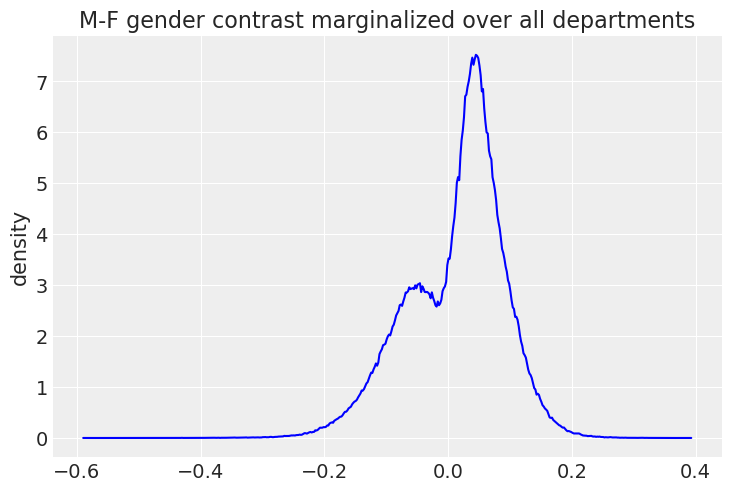

In [134]:
#visualize difference
fig, ax = plt.subplots()
ax.set_title('M-F gender contrast marginalized over all departments')
ax.set_ylabel('density')

az.plot_kde(p_diff, ax=ax, plot_kwargs={"color":'b'});

In [128]:
p_diff.mean()

0.013011266744305094